In [111]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import torch
from scipy.ndimage.filters import gaussian_filter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [429]:
import keras
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, Reshape, Dense, Lambda, Flatten
from keras import backend as K
from keras import optimizers
from mpl_toolkits import mplot3d

# 1. Generate polynomials

Here we use fourth degree polynomials $ax^{4} + bx^{3} + cx^{2} + dx + e$

In [95]:
def f(x, p):
    """
    p = [a, b, c, d, e]
    """
    return p[0]*x**4 + p[1]*x**3 + p[2]*x**2 + p[3]*x + p[4]

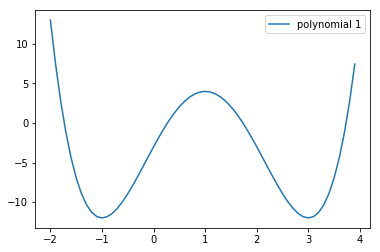

In [96]:
x = np.arange(-2, 4, 0.1)
fx1 = f(x, [1, -4, -2, 12, -3])

plt.plot(x, fx1, label="polynomial 1")
plt.legend()
plt.show()

# 2. Using B-splines to fit the sample points

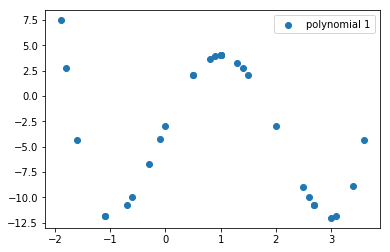

In [97]:
x_sample = np.random.choice(x, 30)
fx1_sample = f(x_sample, [1, -4, -2, 12, -3])

plt.scatter(x_sample, fx1_sample, label="polynomial 1")
plt.legend()
plt.show()

t: [-2.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00
 -1.80000000e+00 -1.70000000e+00 -1.60000000e+00 -1.50000000e+00
 -1.40000000e+00 -1.30000000e+00 -1.20000000e+00 -1.10000000e+00
 -1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01  1.77635684e-15  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01
  1.00000000e+00  1.10000000e+00  1.20000000e+00  1.30000000e+00
  1.40000000e+00  1.50000000e+00  1.60000000e+00  1.70000000e+00
  1.80000000e+00  1.90000000e+00  2.00000000e+00  2.10000000e+00
  2.20000000e+00  2.30000000e+00  2.40000000e+00  2.50000000e+00
  2.60000000e+00  2.70000000e+00  2.80000000e+00  2.90000000e+00
  3.00000000e+00  3.10000000e+00  3.20000000e+00  3.30000000e+00
  3.40000000e+00  3.50000000e+00  3.60000000e+00  3.70000000e+00
  3.90000000e+00  3.90

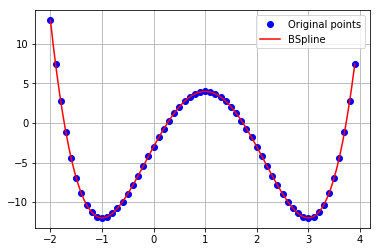

In [98]:
# k Degree 3 Beizer curves
t, c, k = interpolate.splrep(x, fx1, s=0, k=3)
print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x, fx1, 'bo', label='Original points')
plt.plot(xx, spline(xx), 'r', label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.show()

# 3. Generate Dataset to feed in VAE or U-Net

(1) Generate 100 random high degree polynomials. 

(2) points -> graph: Create 100 * 100 numpy matrices for training data. Each point is treated as a pixel.

(3) Create Gaussian blending on the graph

In [204]:
def generate_polynomials(n, xrange, loc, scale, degree):
    """
    n: number of polynomials
    xrange: [lowerbound, upperbound]
    loc: mu
    scale: sigma
    degree: the degree of polynomial
    """
    X = np.zeros((n, xrange.shape[0]))
    for i in range(n):
        p = np.poly1d(np.random.normal(loc=loc, scale=scale, size=degree+1))
        # Randomly generate coefficients for the polynomial.
        X[i] = np.minimum(np.abs(p(xrange)*3), xrange.shape[0]-1).astype("int64")
    return X

def generate_image(X):
    """
    convert 2-D points to 2-D images
    """
    image = np.zeros((X.shape[0], X.shape[1], X.shape[1]))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            image[i, j, int(X[i, j])] = 1.0
    return image

In [213]:
xrange = np.arange(-1, 1, 0.02)
polynomials = generate_polynomials(10000, xrange, 0, 10, 6)
X = np.expand_dims(generate_image(polynomials), axis=1)
y = gaussian_filter(X, sigma=[0, 0, 2, 2])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

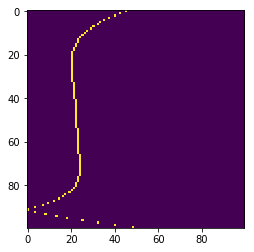

In [214]:
plt.imshow(X_train[350, 0])

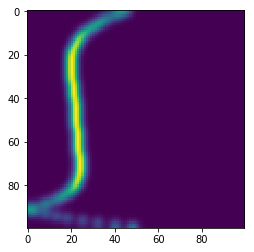

In [215]:
plt.imshow(y_train[350,0])

# 4. Apply VAE

In [195]:
class VAE(nn.Module):
    def __init__(self, in_channel=1, out_channel=1, img_size=(100, 100), latent_size=256):
        super(VAE, self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.img_size = img_size
        self.latent_size = latent_size
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channel, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(25 * 25 * 16, latent_size)
        self.fc_bn1 = nn.BatchNorm1d(latent_size)
        self.fc21 = nn.Linear(latent_size, latent_size)
        self.fc22 = nn.Linear(latent_size, latent_size)
        # Sampling vector
        self.fc3 = nn.Linear(latent_size, latent_size)
        self.fc_bn3 = nn.BatchNorm1d(latent_size)
        self.fc4 = nn.Linear(latent_size, 25 * 25 * 16)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 16)
        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, out_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 16*25*25)
        
        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        mu = self.fc21(fc1)
        std = self.fc22(fc1)
        
        std = std.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        z = eps.mul(std).add_(mu)
        
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 25, 25)
        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        out = self.conv8(conv7).view(-1, self.out_channel, self.img_size[0], self.img_size[1])
        
        return(out, mu, std)


class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
        
    def weighted_mse_loss(self, inputs, targets, w):
        return (((inputs-targets) * w) **2).mean()
    
    def forward(self, recon_x, x, mu, logvar, w):
        MSE = self.weighted_mse_loss(recon_x, x, w)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2)-logvar.exp())
        return MSE + KLD

In [196]:
batch_size = 128

net = VAE()
net = net.double()

criterion = VAELoss()

train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

optimizer = optim.Adam(net.parameters(), lr=0.001)

In [197]:
for epoch in range(10):  # loop over the dataset multiple times
    print("epoch: ", epoch)

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # weights
        alpha = 100
        w = torch.tensor((inputs.detach().numpy() > 0) * alpha, dtype=torch.double)

        # forward + backward + optimize
        out, mu, std = net(inputs)
        loss = criterion(out, labels, mu, std, w)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if i % 10 == 0:
            print("loss:", loss.item())

print('Finished Training')

epoch:  0
loss: 13372.81237840999
loss: 6607.065043694624
loss: 3506.1495870680824
loss: 2079.6651292601778
loss: 1302.742080697025
loss: 908.1097886952249
epoch:  1
loss: 684.0561660831945
loss: 543.8426432846231
loss: 449.14097640459505
loss: 357.22855160433943
loss: 298.00397175136817
loss: 260.66272468451047
epoch:  2
loss: 238.0556538781113
loss: 200.4355778477366
loss: 174.98112072073442
loss: 154.11703722673838
loss: 140.5855487151901
loss: 133.1674475640426
epoch:  3
loss: 113.77820284419398
loss: 105.17680687445335
loss: 98.47891946800394
loss: 91.53750718547845
loss: 78.94996060179524
loss: 72.84068849409617
epoch:  4
loss: 76.8779687112563
loss: 64.37414883709671
loss: 59.19449489131418
loss: 55.30494932150006
loss: 52.76851346904969
loss: 51.36647240633907
epoch:  5
loss: 46.08123304899104
loss: 43.28780604889309
loss: 42.5354076337491
loss: 40.20539376286827
loss: 39.30382534205682
loss: 34.44042678126739
epoch:  6
loss: 32.75837715174631
loss: 32.89301038374197
loss: 29.7

In [198]:
dataiter = iter(testloader)
images, labels = dataiter.next()

out, mu, std  = net(images)

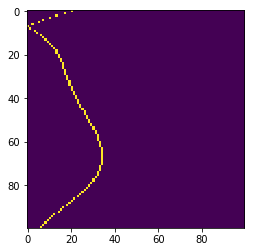

In [199]:
plt.imshow(images[20,0])

In [200]:
out = out.detach().numpy()

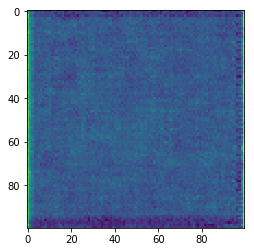

In [201]:
plt.imshow(out[0,0])

# 5. VAE with Keras to Complete 2D Points

In [405]:
def define_encoder_block(x, num_filters):  
    """
    Todo: Define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 2D max pooling layer (MaxPooling2D) (you can keep default arguments).
    """
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling2D()(x)
    return x

def define_decoder_block(x, num_filters):
    """
    Todo: Define one 2D upsampling layer (UpSampling2D) (you can keep default arguments).
          Also, define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

def define_net(variational, height, width, channel, batch_size, latent_dim, conditioning_dim=0,
               start_filters=8,):
    """Defines a (variational) encoder-decoder architecture.
    
    Args:
        variational: Whether a variational autoencoder should be defined.
        height: The height of the image input and output.
        width: The width of the image input and output.
        channel: Number of channels of the image.
        batch_size: The batchsize that is used during training. Must also be used for inference on the encoder side.
        latent_dim: The dimension of the latent space.
        conditioning_dim: The dimension of the space of variables to condition on. Can be zero for an unconditional VAE.
        start_filters: The number of filters to start from. Multiples of this value are used across the network. Can be used
            to change model capacity.
        
    Returns:
        Tuple of keras models for full VAE, encoder part and decoder part only.
    """
    
    # Prepare the inputs.
    inputs = Input((height, width, channel))
    if conditioning_dim > 0:
        # Define conditional VAE. Note that this is usually not the preferred way
        # of incorporating the conditioning information in the encoder.
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width)(condition)
        condition_up = Reshape([height, width, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs
    
    # Define the encoder.
    eblock1 = define_encoder_block(inputs_new, start_filters)
    eblock2 = define_encoder_block(eblock1, start_filters*2)
    eblock3 = define_encoder_block(eblock2, start_filters*4)
    eblock4 = define_encoder_block(eblock3, start_filters*8)
    _, *shape_spatial = eblock4.get_shape().as_list()
    eblock4_flat = Flatten()(eblock4)
    
    if not variational:
        z = Dense(latent_dim)(eblock4_flat)
    else:
        # Perform the sampling.
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon
        
        z_mean = Dense(latent_dim)(eblock4_flat)
        z_log_sigma = Dense(latent_dim)(eblock4_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

    # Define the decoder.
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock4.shape.as_list()[1:])(embedding)
        
    dblock1 = define_decoder_block(embedding, start_filters*8)
    dblock2 = define_decoder_block(dblock1, start_filters*4)
    dblock3 = define_decoder_block(dblock2, start_filters*2)
    dblock4 = define_decoder_block(dblock3, start_filters)
    output = Conv2D(channel, 1, activation = 'tanh')(dblock4)
    
    # Define the models.
    decoder = Model(input = inputs_embedding, output = output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model(input = [inputs, condition], output = z)
        encoder_with_sampling_ext = Model(input = [inputs, condition], output = z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model(input = [inputs, condition], output = vae_out)
    else:
        encoder_with_sampling = Model(input = inputs, output = z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(input = inputs, output = vae_out)
    
    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
        mse_loss = K.mean(keras.losses.mse(x, x_decoded_mean), axis=(1,2)) * height * width
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss
    
    if variational:
        vae.compile(loss=vae_loss, optimizer='adam')
    else:
        vae.compile(loss='mse', optimizer='adam')    
        
    print('done,', vae.count_params(), 'parameters.')
    return vae, encoder_with_sampling, decoder

In [406]:
xrange = np.linspace(-1, 1, 128)
polynomials = generate_polynomials(10000, xrange, 0, 10, 6)
X = np.expand_dims(generate_image(polynomials), axis=3)
y = gaussian_filter(X, sigma=[0, 2, 2, 0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [407]:
vae, encoder, decoder = define_net(
    True, 128, 128, 1, batch_size=50, latent_dim=10, start_filters=4)

done, 109581 parameters.


/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


In [408]:
vae.fit(X_train, y_train, batch_size=50, verbose=1, epochs=2)

Epoch 1/2
7500/7500 [==============================] - 161s 22ms/step - loss: 9.4570
Epoch 2/2
7500/7500 [==============================] - 149s 20ms/step - loss: 4.6363


In [417]:
vae.save("2DVAE.h5")

In [415]:
y_predict2 = vae.predict(X_train, batch_size=50)

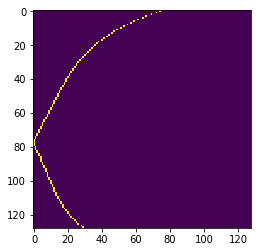

In [412]:
plt.imshow(X_train[150, :, :, 0])

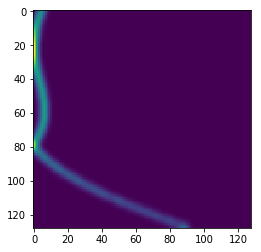

In [329]:
plt.imshow(y_train[10, :, :, 0])

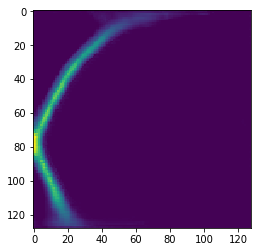

In [416]:
plt.imshow(y_predict2[150, :, :, 0])

# 6. Generate 3D points 

In [361]:
def generate_polynomials_3d(n, trange, loc, scale, degree):
    """
    n: number of polynomials
    trange: [lowerbound, upperbound]
    loc: mu
    scale: sigma
    degree: the degree of polynomial
    """
    X = np.zeros((n, 3, trange.shape[0]))
    for i in range(n):
        px = np.poly1d(np.random.normal(loc=loc, scale=scale, size=degree+1))
        py = np.poly1d(np.random.normal(loc=loc, scale=scale, size=degree+1))
        pz = np.poly1d(np.random.normal(loc=loc, scale=scale, size=degree+1))
        # Randomly generate coefficients for the polynomial.
        X[i][0] = np.minimum(np.abs(px(trange)*3), trange.shape[0]-1).astype("int64")
        X[i][1] = np.minimum(np.abs(py(trange)*3), trange.shape[0]-1).astype("int64")
        X[i][2] = np.minimum(np.abs(pz(trange)*3), trange.shape[0]-1).astype("int64")

    return X

def generate_image_3d(X):
    """
    convert 3-D points to 3-D images
    """
    image = np.zeros((X.shape[0], X.shape[2], X.shape[2], X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            image[i, int(X[i, 0, j]), int(X[i, 1, j]), int(X[i, 2, j])] = 1.0
    return image

In [420]:
trange = np.linspace(-1, 1, 128)
polynomials = generate_polynomials_3d(200, trange, 0, 10, 6)
image = generate_image_3d(polynomials)
X = np.expand_dims(generate_image_3d(polynomials), axis=5)
y = gaussian_filter(X, sigma=[0, 2, 2, 2, 0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


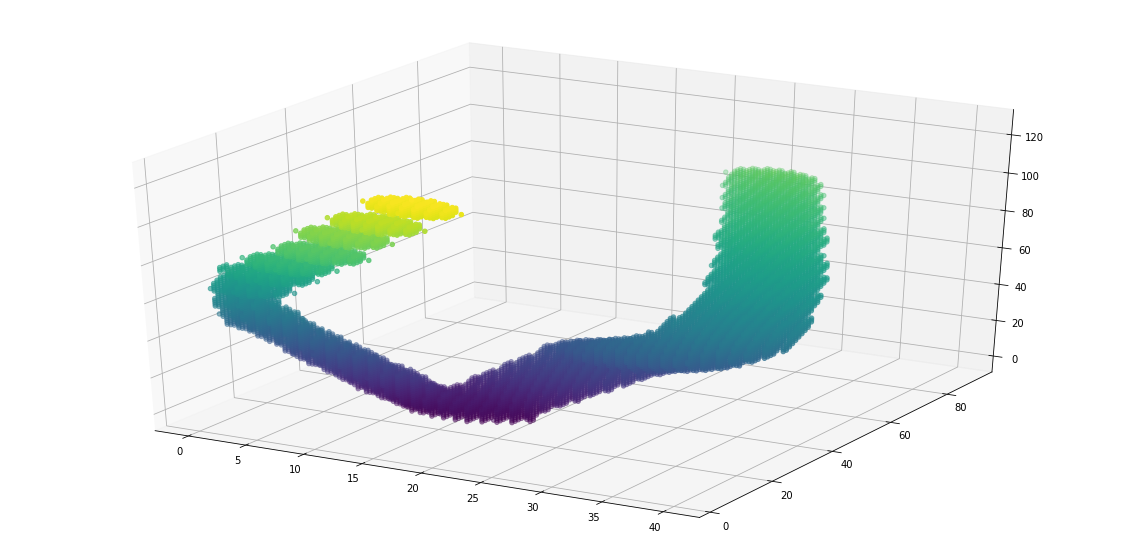

In [393]:
indexes = np.argwhere(y[0, :, :, :, 0] > 0.001)

fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

zdata = indexes[:, 0]
xdata = indexes[:, 1]
ydata = indexes[:, 2]
ax.scatter3D(xdata, ydata, zdata, c=zdata)

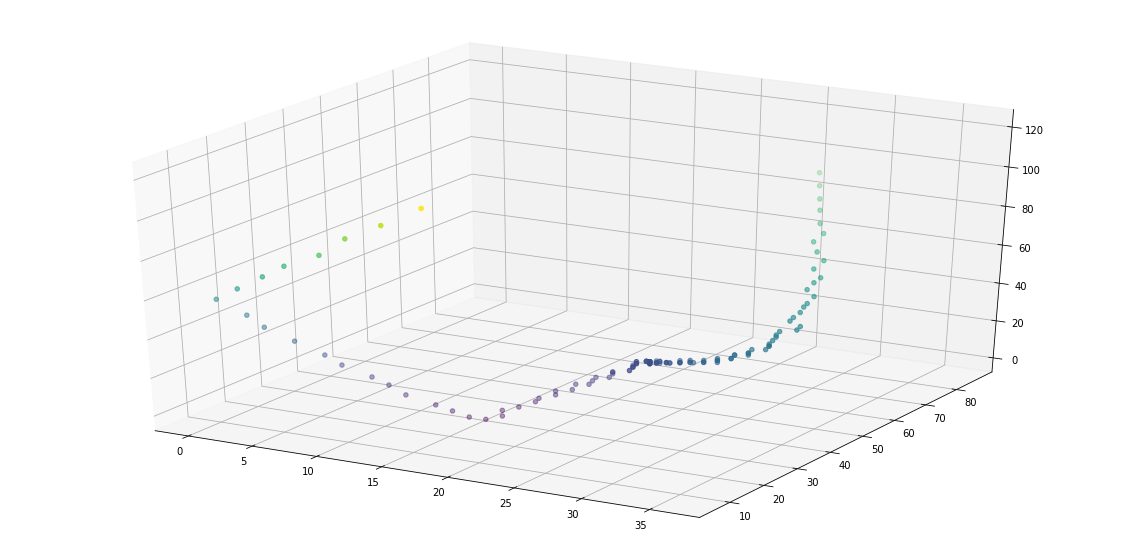

In [381]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

zdata = polynomials[0, 0]
xdata = polynomials[0, 1]
ydata = polynomials[0, 2]
ax.scatter3D(xdata, ydata, zdata, c=zdata)

# 7. VAE with Keras to generate 3D points

In [422]:
def define_encoder_block(x, num_filters):  
    """
    Todo: Define two sequential 3D convolutional layers (Conv3D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 3D max pooling layer (MaxPooling3D) (you can keep default arguments).
    """
    x = Conv3D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv3D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling3D()(x)
    return x

def define_decoder_block(x, num_filters):
    """
    Todo: Define one 3D upsampling layer (UpSampling3D) (you can keep default arguments).
          Also, define two sequential 3D convolutional layers (Conv3D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = UpSampling3D()(x)
    x = Conv3D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv3D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

def define_net(variational, height, width, depth, channel, batch_size, latent_dim, conditioning_dim=0,
               start_filters=8,):
    """Defines a (variational) encoder-decoder architecture.
    
    Args:
        variational: Whether a variational autoencoder should be defined.
        height: The height of the image input and output.
        width: The width of the image input and output.
        channel: Number of channels of the image.
        batch_size: The batchsize that is used during training. Must also be used for inference on the encoder side.
        latent_dim: The dimension of the latent space.
        conditioning_dim: The dimension of the space of variables to condition on. Can be zero for an unconditional VAE.
        start_filters: The number of filters to start from. Multiples of this value are used across the network. Can be used
            to change model capacity.
        
    Returns:
        Tuple of keras models for full VAE, encoder part and decoder part only.
    """
    
    # Prepare the inputs.
    inputs = Input((height, width, depth, channel))
    if conditioning_dim > 0:
        # Define conditional VAE. Note that this is usually not the preferred way
        # of incorporating the conditioning information in the encoder.
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width * depth)(condition)
        condition_up = Reshape([height, width, depth, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs
    
    # Define the encoder.
    eblock1 = define_encoder_block(inputs_new, start_filters)
    eblock2 = define_encoder_block(eblock1, start_filters*2)
    eblock3 = define_encoder_block(eblock2, start_filters*4)
    eblock4 = define_encoder_block(eblock3, start_filters*8)
    _, *shape_spatial = eblock4.get_shape().as_list()
    eblock4_flat = Flatten()(eblock4)
    
    if not variational:
        z = Dense(latent_dim)(eblock4_flat)
    else:
        # Perform the sampling.
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon
        
        z_mean = Dense(latent_dim)(eblock4_flat)
        z_log_sigma = Dense(latent_dim)(eblock4_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

    # Define the decoder.
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock4.shape.as_list()[1:])(embedding)
        
    dblock1 = define_decoder_block(embedding, start_filters*8)
    dblock2 = define_decoder_block(dblock1, start_filters*4)
    dblock3 = define_decoder_block(dblock2, start_filters*2)
    dblock4 = define_decoder_block(dblock3, start_filters)
    output = Conv3D(channel, 1, activation = 'tanh')(dblock4)
    
    # Define the models.
    decoder = Model(input = inputs_embedding, output = output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model(input = [inputs, condition], output = z)
        encoder_with_sampling_ext = Model(input = [inputs, condition], output = z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model(input = [inputs, condition], output = vae_out)
    else:
        encoder_with_sampling = Model(input = inputs, output = z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(input = inputs, output = vae_out)
    
    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
        mse_loss = K.mean(keras.losses.mse(x, x_decoded_mean), axis=(1,2,3)) * height * width * depth
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss

    if variational:
        vae.compile(loss=vae_loss, optimizer='adam')
    else:
        vae.compile(loss='mse', optimizer='adam')    
        
    print('done,', vae.count_params(), 'parameters.')
    return vae, encoder_with_sampling, decoder

In [430]:
vae3d, encoder3d, decoder3d = define_net(
    True, 128, 128, 128, 1, batch_size=10, latent_dim=10, start_filters=4)

done, 645653 parameters.


/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
/Users/zhaohongjin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


In [431]:
vae3d.fit(X_train, y_train, batch_size=10, verbose=1, epochs=10)

Epoch 1/10


KeyboardInterrupt: 